## Customize the pulse-level simulation

QuTiP is an open-source software library for simulating the dynamics of open quantum systems. It provides a powerful and flexible framework for simulating the time evolution of quantum systems, including both Hamiltonian-driven dynamics and Lindblad master equation-driven dynamics. One of the key features of QuTiP is the ability to customize the pulse-level simulation.

By using the pulse-level simulation, users can create sequences of control pulses that drive the quantum system from one state to another. These pulses can be shaped and optimized to achieve a specific target, such as maximizing the population transfer or minimizing the errors in the final state. The pulse-level simulation in QuTiP allows for a high level of control over the pulse parameters, including the amplitude, frequency, phase, and duration.

-----

To use the pulse-level simulation in QuTiP, users first need to define the quantum system they want to simulate and the target state. Then, they can create a set of pulses using the available pulse generators, such as Gaussian, Sine, Square, and other types of pulses. The pulses can be combined and optimized using a variety of optimization algorithms, such as gradient ascent, gradient descent, and Powell's method.

-----

In conclusion, the pulse-level simulation in QuTiP is a powerful tool for quantum control and optimization. It provides users with the ability to create and customize sequences of control pulses that drive quantum systems to a desired target state. This makes it a valuable resource for quantum engineers, physicists, and researchers working in the field of quantum information and quantum technologies.

In [1]:
%pip install qutip
%pip install qutip_qip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 47.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 KB 3.7 MB/s eta 0:00:00


In this note, we demonstrate examples of customizing the pulse-level simulator in qutip-qip.The notebook is divided into three parts:

<li> Customizing the Hamiltonian model
<li> Customizing the compiler
<li> Customizing the noise

In [2]:
# imports
import numpy as np

from qutip import sigmax, sigmay, sigmaz, tensor, fidelity
from qutip import basis

from qutip_qip.pulse import Pulse
from qutip_qip.device import ModelProcessor, Model
from qutip_qip.circuit import QubitCircuit
from qutip_qip.compiler import GateCompiler, Instruction, SpinChainCompiler
from qutip_qip.noise import Noise

import matplotlib.pyplot as plt

## Customizing the Hamiltonian model
We start from the customization of the Hamiltonian model, which is represented by a class instance of `Model`.A minimal requirement for a processor model is specifying the hardware parameters and the control Hamiltonians of the physical system. The former will be provided to the compiler for computing the pulse strength. The latter will be accessed by the `Processor` class via the method `get_control`.



In [3]:
class MyModel(Model):
    def __init__(self, num_qubits, dims=None, h_x=1., h_z=1., g=0.1, t1=None, t2=None):
        super().__init__(num_qubits, dims=dims)
        self.params = {
            "sz": [h_z] * num_qubits,
            "sx": [h_x] * num_qubits,
            "g": [g] * num_qubits,
            "t1": t1, #  Will be accessed by the noise module.
            "t2": t2,
        }
        # Control Hamiltonians
        _two_qubit_operator = tensor([sigmax(), sigmax()]) + tensor([sigmay(), sigmay()])
        self.controls = {}
        self.controls.update(
            {f"sx{n}": (2 * np.pi * sigmax(), n) for n in range(num_qubits)})
        self.controls.update(
            {f"sz{n}": (2 * np.pi * sigmaz(), n) for n in range(num_qubits)}),
        self.controls.update(
            {f"g{n}": (2 * np.pi * _two_qubit_operator, [n, n+1]) for n in range(num_qubits - 1)}),
        
    def get_control(self, label):
        """
        The mandatory method. It Returns a pair of Qobj and int representing the control Hamiltonian and the target qubit.
        """
        return self.controls[label]

    def get_control_labels(self):
        """
        It returns all the labels of availble controls.
        """
        return self.controls.keys()

    def get_control_latex(self):
        """
        The function returns a list of dictionaries, corresponding to the latex representation of each control.
        This is used in the plotting. Controls in each dictionary will be plotted in a different colour.
        See examples later in this notebook.
        """
        return ([
            {f"sx{n}": r"$\sigma_x^%d$" % n for n in range(num_qubits)},
            {f"sy{n}": r"$\sigma_z^%d$" % n for n in range(num_qubits)},
            {f"g{n}": r"$g_{%d}$" % (n) for n in range(num_qubits - 1)}])

This is a quantum system of n
 qubits arranged in a chain (same as the spin chain model), where we have control over three Hamiltonian: $σ_x
, σ_z$
 on each qubit, and neighbouring-qubits interaction $\sigma_x\sigma_x+\sigma_y\sigma_y
$

$$H = \sum_{j=0}^{n-1} c_{1,j}(t) \cdot h_x^{j}\sigma_x^{j} + \sum_{j=0}^{n-1} c_{2,j}(t) \cdot h_z^{j}\sigma_z^{j}
+ \sum_{j=0}^{n-2} c_{3,j}(t)\cdot g^{j}(\sigma_x^{j}\sigma_x^{j+1}+\sigma_y^{j}\sigma_y^{j+1})
$$

where $h_x, h_z, g$ are the hardware parameters and $c_{i,j}(t)$  are the time-dependent control pulse coefficients. This Hamiltonian is the same as the one for the linear spin chain model in QuTiP. In general, the hardware parameters will not be identical for each qubit, but here, for simplicity, we represent them by three numbers: $h_x, h_z, g$ 

-------

To simulate a custom quantum device, we provide the model to `ModelProcessor`, which is used for simulators based on a concrete physics model (in contrast to optimal control for arbitrary Hamiltonians). In this way, we inherit the necessary methods from `ModelProcessor` used in the simulation


In [4]:
num_qubits = 2
processor = ModelProcessor(model=MyModel(num_qubits, h_x=1.0, h_z=1.0, g=0.1))

In `set_up_ops`, we define the control Hamiltonians of the quantum system and use them to initialize the control pulses. We can get the map between the pulse labels and the pulse location with

In [5]:
processor.get_control_labels()

dict_keys(['sx0', 'sx1', 'sz0', 'sz1', 'g0'])

Or access a control Hamiltonian by its label:

In [6]:
sx0 = processor.get_control("sx0")
sx0

(Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.         6.28318531]
  [6.28318531 0.        ]], 0)

In qutip-qip 0.1 version, the model is directly defined in the Processor. This can still be achieved in version 0.2 as shown in the following cell. This is equivalent to the definition above. An instance of Model is automatically created and saved in the processor.

In [7]:
class MyProcessor(ModelProcessor):
    """
    Custom processor built using ModelProcessor as the base class.
    This custom processor will inherit all the methods of the base class
    such as setting up of the T1 and T2 decoherence rates in the simulations.

    In addition, it is possible to write your own functions to add control pulses.

    Args:
        num_qubits (int): Number of qubits in the processor.
        t1, t2 (float or list): The T1 and T2 decoherence rates for the
    """
    def __init__(self, num_qubits, h_x, h_z, g, t1=None, t2=None):
        super(MyProcessor, self).__init__(num_qubits, t1=t1, t2=t2)  # call the parent class initializer
        self.pulse_mode = "discrete"  # The control pulse is discrete or continous.
        self.model.params.update({"sz": [h_z] * num_qubits,  # can also be different for each qubit
                       "sx": [h_x] * num_qubits,
                       "g": [g] * num_qubits})
        self.model.dims = [2] * num_qubits  # The dimension of each controllable quantum system, here num_qubits qubits.
        self.num_qubits = num_qubits
        self.set_up_ops()  # set up the available Hamiltonians

    def set_up_ops(self):
        """
        Sets up the control operators.
        """
        for m in range(self.num_qubits):
            # sigmax pulse on m-th qubit with the corresponding pulse 
            self.add_control(2 * np.pi * sigmax(), m, label="sx" + str(m))
        # sz
        for m in range(self.num_qubits):
            self.add_control(2 * np.pi * sigmaz(), m, label="sz" + str(m))
        # interaction operator
        operator = tensor([sigmax(), sigmax()]) + tensor([sigmay(), sigmay()])
        for m in range(self.num_qubits - 1):
            self.add_control(2 * np.pi * operator, [m, m+1], label="g" + str(m))

## Load and compile the circuit
We first define a quantum circuit. Here we use a two-qubit circuit with two X gates. Acting on a |00⟩
 state, this results in a |11⟩
 state.

In [8]:
circuit = QubitCircuit(num_qubits)
circuit.add_gate("X", targets=1)
circuit.add_gate("X", targets=0)
circuit

To convert a quantum circuit into the Hamiltonian model, we need a compiler. The custom definition of a compiler will be discussed in details in the next section. Because we used the Hamiltonian model of the spin chain, we here simply "borrow" the compiler of the spin chain model

In [10]:
processor = ModelProcessor(model=MyModel(num_qubits, h_x=1.0, h_z=1.0, g=0.1))
processor.native_gates = ["ISWAP", "RX", "RZ"]

# processor.num_qubits, processor.params access directly the information in the model.
compiler = SpinChainCompiler(processor.num_qubits, processor.params)

processor.load_circuit(circuit, compiler=compiler)
result = processor.run_state(init_state = basis([2,2], [0,0]))
print(result.states[-1])

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 3.44966415e-07+0.00000000e+00j]
 [ 0.00000000e+00+1.62361791e-08j]
 [ 0.00000000e+00+1.62361791e-08j]
 [-1.00000000e+00+0.00000000e+00j]]


The compiled pulse coefficients are now saved in the processor and can be accessed by:

In [11]:
sx1_pulse = processor.find_pulse("sx1")
print(sx1_pulse.coeff)
print(sx1_pulse.tlist)

[1.]
[0.   0.25]


For discrete pulse, the time sequence is one element shorter than the pulse coefficient because we need to specify the start and the end of the pulse. If two sequences are of the same length, the last element of coeff will be neglected. Later, we will see continuous pulse where coeff and tlist have the same length.

To give an intuitive illustration of the control pulses, we give each pulse a latex label by defining a method get_operators_labels and then plot the compiled pulses.

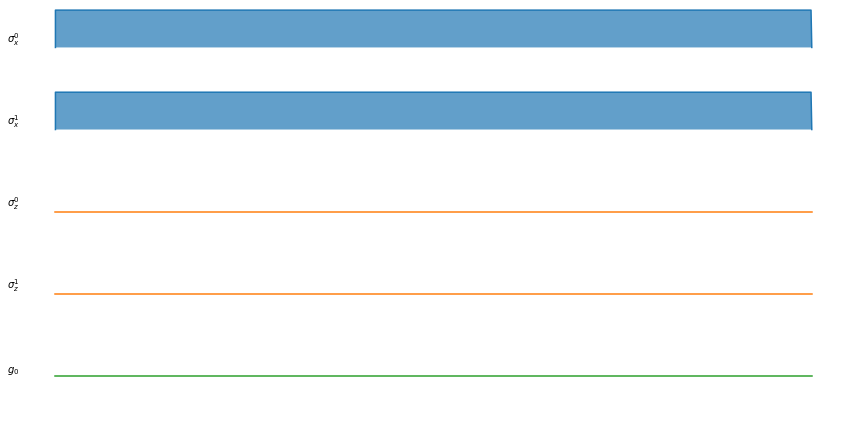

In [12]:
processor.plot_pulses()
plt.show()

## Customizing the compiler
How the quantum gates are implemented on hardware varies on different quantum systems. Even on the same physical platform, different implementation will yield different performance. The simplest way of implementation is to define a rectangular pulse like the one above. However, in reality, the control signal will have a continuous shape. In the following, we show how to customize the compiler with a gaussian pulse.

A typical gate compiler function looks like the one in the following cell, with the form XX_compiler(self, gate, args). It takes two arguments, gate and args: gate is the quantum gate to be compiled and args is a dictionary for additional parameters, for instance, parameters we defined in Processor.params.

For each gate, the function returns the input gate, the time sequence and the pulse coefficients in an Instruction object.

Below is an example of a rectangular pulse.

In [13]:
def rz_compiler(gate, args):
    """
    Compiles the RZ gate to an instruction for a pulse.

    Args:
        gate (qutip_qip.circuit.Gate): A qutip Gate object.
        args:(dict): A dictionary for compilation arguments e.g. hardware parameters.

    Returns:
        Instruction (qutip_qip.compiler.instruction.Instruction): An instruction to implement
                                                                  a gate containing the control
                                                                  pulses.
    """
    tlist = np.array([1.])
    coeff = np.array([0., 0.25])
    # instruction is an object that includes the pulse coefficient and time sequence
    pulse_info = [("sz0", coeff)]
    return [Instruction(gate, tlist, pulse_info)]

Now we replace it with a continuous pulse. In particular, we define a single_qubit_compiler method. For RX and RY gate, it reads the maximal driving strength from the parameters and computes the corresponding time sequence and pulse amplitude.

For simplicity, we make use of the generate_pulse_shape method, which is defined in the parent class GateCompiler and is available in all subclasses.

In [14]:
class MyCompiler(GateCompiler):  # compiler class
    def __init__(self, num_qubits, params):
        super(MyCompiler, self).__init__(num_qubits, params=params)
        # pass our compiler function as a compiler for X gate.
        self.gate_compiler["X"] = self.single_qubit_compiler
        self.gate_compiler["Y"] = self.single_qubit_compiler
        self.args.update({"params": params})

    def single_qubit_compiler(self, gate, args):
        """
        Compiler for the X and Y gate.
        """
        targets = gate.targets
        if gate.name == "Z":
            pulse_prefix = "sz"
            pulse_strength = args["params"]["sz"][targets[0]]
        elif gate.name == "X":
            pulse_prefix = "sx"
            pulse_strength = args["params"]["sx"][targets[0]]
        coeff, tlist= self.generate_pulse_shape(
                "hann",  # Scipy Hann window
                100,  # 100 sampling point
                maximum=pulse_strength,
                area= (np.pi/2) / (2*np.pi),  # 1/2 becuase we use sigmax as the operator instead of sigmax/2
            )
        sign = np.sign(pulse_strength)
        pulse_info = [(pulse_prefix + str(targets[0]), coeff)]
        return [Instruction(gate, tlist, pulse_info)]

The attribute pulse_mode can be set to "discrete" or "continuous". For continuous pulse, QuTiP solvers will use cubic spline interpolation. To minimize the boundary effect, it is recommended that the continuous pulse goes smoothly to 0 at the beginning and the end. We can see the advantage of the scheduling when we introduce a T1 decoherence and compare the fidelity of the final state.

In [15]:
gauss_compiler = MyCompiler(processor.num_qubits, processor.params)
processor = ModelProcessor(model=MyModel(num_qubits, h_x=1.0, h_z=1.0, g=0.1, t1=300))
processor.pulse_mode = "continuous"
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler, schedule_mode = False);
print
result = processor.run_state(init_state = basis([2,2], [0,0]))
print("fidelity without scheduling:", fidelity(result.states[-1], basis([2,2],[1,1])))

fidelity without scheduling: 0.9984504390654066


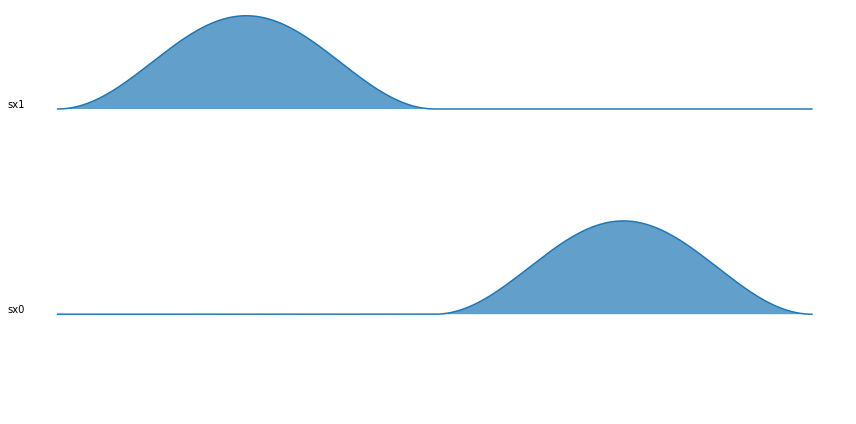

In [16]:
processor.plot_pulses(use_control_latex=False)
plt.show()

We can also turn on the scheduler to schedule the circuit for a shorter execution time.

In [17]:
processor = ModelProcessor(model=MyModel(num_qubits, h_x=1.0, h_z=1.0, g=0.1, t1=300))
tlist, coeffs = processor.load_circuit(circuit, schedule_mode = "ASAP", compiler=gauss_compiler);
processor.pulse_mode = "continuous"
result = processor.run_state(init_state = basis([2,2], [0,0]))
print("fidelity with scheduling:", fidelity(result.states[-1], basis([2,2],[1,1])))

fidelity with scheduling: 0.9992832518623955


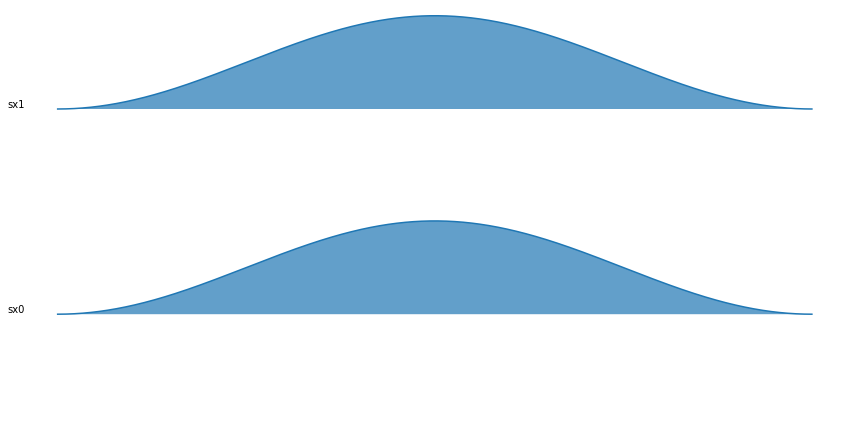

In [18]:
processor.plot_pulses(use_control_latex=False)
plt.show()

## Define your own gate
The number of predefined gates in qutip is limited, hence you are encouraged to define your own gate. Here we show how to define a parametrized gate. First, you will need to define a gate function:

In [19]:
def mygate(theta = None):
    # We just call the Molmer Sorensen gate as an example.
    # If you do not want to run the circuit at the gate matrix level (circuit.run), no need for this function,
    # otherwise you will need to define this python function that returns the Qobj of the gate.)
    from qutip_qip.operations import molmer_sorensen
    return molmer_sorensen(theta, 2, targets=[0, 1])
circuit = QubitCircuit(2)
circuit.user_gates = {"MYGATE": mygate}  # no need for this if you don't use circuit.run
circuit.add_gate("X", targets=1)
circuit.add_gate("MYGATE", targets=[0,1], arg_value=3*np.pi/2)
circuit.add_gate("X", targets=0)
circuit
# You may see a warning because MYGATE is not found in defined LaTeX gate names, just ignore it.


In [20]:
circuit.run(basis([2,2],[0,0]))

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        -0.70710678j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.70710678+0.j        ]]

The next step is to define a compiler function for it. Since compiling a real MS gate is rather complicated, we here just use a dummy triangular pulse. The goal is to show how to get access to the parameter theta during the compiling.

In [21]:
def mygate_compiler(gate, args):
    targets = gate.targets  # target qubit
    parameters = args["params"]
    
    theta = gate.arg_value
    coeff1 = np.concatenate([np.linspace(0,10,50), np.linspace(10,0,50), [0]]) / 50
    coeff2 = np.concatenate([np.linspace(0,10,50), np.linspace(10,0,50), [0]]) / 50
    pulse_info = [("sx" + str(targets[0]), theta * coeff1),
                  ("sx" + str(targets[1]), theta * coeff2)
                 ]  #  save the information in a tuple (pulse_name, coeff)
    tlist = np.linspace(0, 1, len(coeff1))
    return [Instruction(gate, tlist, pulse_info)]

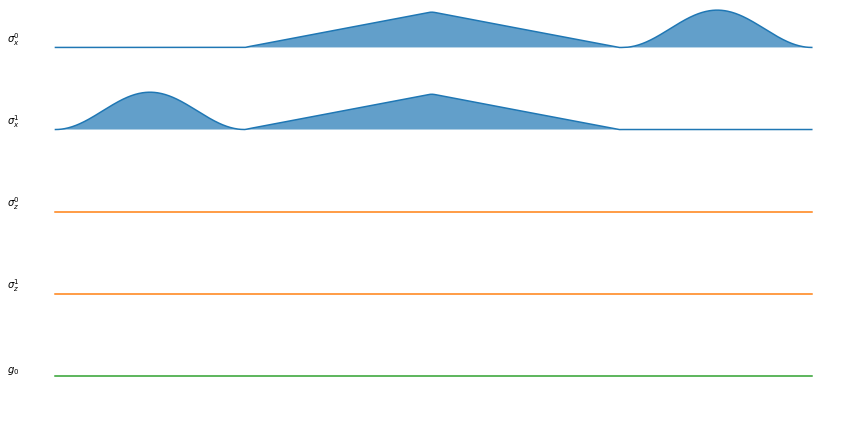

In [22]:
gauss_compiler = MyCompiler(processor.num_qubits, processor.params)
processor = ModelProcessor(model=MyModel(num_qubits, h_x=1.0, h_z=1.0, g=0.1, t1=300))
gauss_compiler.gate_compiler["MYGATE"] = mygate_compiler
processor.pulse_mode = "continuous"
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler)
processor.plot_pulses()
plt.show()

Customizing the noise
Apart from pre-defined noise such as T1, T2 noise and random noise in the control pulse amplitude ( one can also define custom noise. Here we will see two examples of customizing noise, one systematic (pulse-independent) noise and one pulse-dependent noise.

-----

To understand how noise is processed, we briefly introduced the data structure of the simulation framework. The control elements are stored as a list of Pulse objects in the Processor. In each Pulse contains the idea pulse, the control noise part and the decoherence part. For systematic noise, it is saved under the Pulse representation labelled "system", which represents the intrinsic dynamics of the quantum system. For pulse-dependent noise, we will add them to their corresponding control Pulse.

----


The definition of noise is realized by a subclass of UserNoise, including two methods:

1. the initialization method containing the property of the noise, such as frequency or amplitude.
2. the method get_noisy_dynamics that takes all the control pulse pulses, a dummy Pulse object representing systematic noise and the dimension of the system (here two qubits [2,2]).

In [23]:
class Extral_decay(Noise):
    def __init__(self, arg):
        self.arg = arg
        pass

    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        pass

## Systematic noise
We first show an example of systematic noise. Here, we introduce a ZZ crosstalk noise between neighbouring qubits with a constant strength. It is done in three steps:

1. Define the noise class.
2. Initialize the noise object with given coupling strength.
3. Define the Processor as usual and add the noise to the processor.


In the following example, we check the fidelity of the same circuit of two X gates, but now with this additional noise.

In [24]:
circuit = QubitCircuit(2)
circuit.add_gate("X", targets=1)
circuit.add_gate("X", targets=0)

In [25]:
from qutip import sigmaz
from qutip_qip.operations import expand_operator
from qutip_qip.pulse import Pulse
from qutip_qip.noise import Noise

class ZZ_crosstalk(Noise):
    def __init__(self, strength):
        self.strength = strength

    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        zz_operator = tensor([sigmaz(), sigmaz()])
        for i in range(len(dims)-1):
            systematic_noise.add_control_noise(
                self.strength * zz_operator, targets=[i,i+1], tlist=None, coeff=True)  # constant, always 1

crosstalk_noise = ZZ_crosstalk(strength=1.0)

In [26]:
processor = ModelProcessor(model=MyModel(num_qubits, h_x=1.0, h_z=1.0, g=0.1))
processor.add_noise(crosstalk_noise)  # The noise is added to the processor
gauss_compiler = MyCompiler(processor.num_qubits, processor.params)
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler);

result = processor.run_state(init_state = basis([2,2], [0,0]))
print("Final fidelity with ZZ crosstalk:", fidelity(result.states[-1],basis([2,2],[1,1])))


Final fidelity with ZZ crosstalk: 0.990291580312767


## Pulse dependent noise
In this second example, we demonstrate how to add an additional amplitude damping channel on the qubits. The amplitude of this decay is linearly dependent on the control pulse "sx", i.e. whenever the pulse "sx" is turned on, the decoherence is also turned on. The corresponding annihilation operator has a coefficient proportional to the control pulse amplitude. This noise can be added on top of the default T1, T2 noise.

In [27]:
from qutip_qip.pulse import Pulse
class Extral_decay(Noise):
    def __init__(self, ratio):
        self.ratio = ratio

    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        from qutip import destroy
        op = destroy(2)
        for pulse in pulses:   # iterate for all pulses
            if "sx" in pulse.label and pulse.coeff is not None:   # if it is a sigma-x pulse and is not empty
                pulse.add_lindblad_noise(op, targets=pulse.targets, tlist=pulse.tlist, coeff=self.ratio * pulse.coeff)
                # One can also use add_control_noise here to add addtional hamiltonian as noise (see next example).

extral_decay = Extral_decay(0.3)

In [28]:
processor = ModelProcessor(model=MyModel(num_qubits, h_x=1.0, h_z=1.0, g=0.1))
processor.add_noise(extral_decay)
gauss_compiler = MyCompiler(processor.num_qubits, processor.params)
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler);

result = processor.run_state(init_state = basis([2,2], [0,0]))
print("Final fidelity with pulse dependent decoherence:", fidelity(result.states[-1],basis([2,2],[1,1])))


Final fidelity with pulse dependent decoherence: 0.9941535563724607


## Software Versions

In [29]:
import qutip_qip
print(qutip_qip.version.version)
from qutip.ipynbtools import version_table
version_table()

0.2.3


Software,Version
QuTiP,4.7.1
Numpy,1.21.6
SciPy,1.7.3
matplotlib,3.2.2
Cython,0.29.33
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,7.9.0
Python,"3.8.10 (default, Nov 14 2022, 12:59:47) [GCC 9.4.0]"
OS,posix [linux]
